In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch


Our functions

In [2]:
from Train_policy_func import Policy, load_policy
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_Scores
from OPPO import baseline_CartPole_v0_Fla, OPPO_update, set_seed
from PPO import evaluate_policy
from RLHF import RewardModel, train_reward_model
from pairs_generator import sample_preference_pairs, compute_reward_from_traj


In [3]:
# Parameters
env_name='CartPole-v0'
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = np.random.choice([35, 42, 100])  # replace with your seed
try:
  pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
  print("pi_1 (very good policy) loaded with seed ", seed, ":=)")
except:
  # arbitrary choice to not generate the policies in this notebook
  print("pi_1 and pi_2 could not be loaded, please verify the files (we do not generate them in this script)")

pi_1 (very good policy) loaded with seed  42 :=)


c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## We need now to create a new policy that performs poorly.

In [4]:
# Hyperparameters
lr_oppo = 0.005
n_episodes              = 50  # low number to undertrain the policy
max_t                   = 200  # cap on steps per episode
print_every             = 10   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


pi_poor     = Policy(state_size=obs_dim, action_size=action_dim).to(device)
opt_poor    = torch.optim.Adam(pi_poor.parameters(), lr=lr_oppo)


#── Run the OPPO training ──
scores_oppo2 = OPPO_update(
    policy       = pi_poor,
    optimizer    = opt_poor,
    env          = env,
    baseline     = baseline_CartPole_v0_Fla,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = True
)


Episode 10 	 Average Score over the last 10 episodes: 17.7
Episode 20 	 Average Score over the last 10 episodes: 18.5
Episode 30 	 Average Score over the last 10 episodes: 13.9
Episode 40 	 Average Score over the last 10 episodes: 18.2
Episode 50 	 Average Score over the last 10 episodes: 21.9


### Somes tests for both good and bad policies:

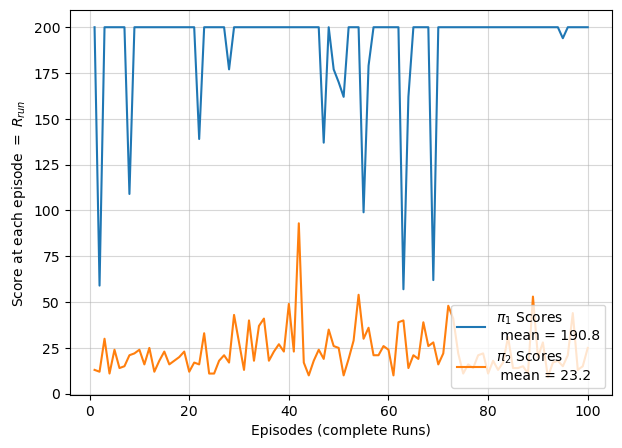

In [5]:

num_episodes = 100

pi1_mean_reward, pi1_rewards     = evaluate_policy(pi_1,     env, n_episodes=num_episodes)
pi2_mean_reward, pi_poor_rewards = evaluate_policy(pi_poor,  env, n_episodes=num_episodes)

plot_Scores(
    pi1_rewards,
    pi_poor_rewards,
)

In [6]:
traj1 = generate_trajectory(pi_1,    env, max_steps=1000)
traj2 = generate_trajectory(pi_poor, env, max_steps=1000)
print("on a test trajectory of maximum 1000 steps")
print(f"pi_1    → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
print(f"pi_poor → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

on a test trajectory of maximum 1000 steps
pi_1    → length 200, total reward 200.0
pi_poor → length 24, total reward 24.0


## Then create the RewardModel and train it

In [ ]:
# n_pairs = 300

for n_pairs in [20, 50, 200, 1000]:
  prefs   = sample_preference_pairs(pi_1, pi_poor, env, K=n_pairs)
  print(f"Collected {n_pairs} preference pairs.")


  lr_reward     = 0.01

  reward_model  = RewardModel(state_dim=obs_dim, action_dim=action_dim).to(device)
  opt_reward    = torch.optim.Adam(reward_model.parameters(), lr=lr_reward)

  train_reward_model(reward_model, prefs, opt_reward, epochs=50)
  total_reward= compute_reward_from_traj(reward_model, traj1)

  # Test the reward model
  correct = 0
  for pair in prefs:
      r_pos = compute_reward_from_traj(reward_model, pair["traj_acc"])
      r_neg = compute_reward_from_traj(reward_model, pair["traj_rej"])
      if r_pos > r_neg:
          correct += 1
  accuracy = correct / len(prefs)
  print(f"Reward model with {n_pairs} pair ranking accuracy: {100*accuracy:.1f} %")

  torch.save(reward_model.state_dict(), f"./Policies/reward_model_{env_name}_Npairs_{n_pairs}.pth")


Collected 20 preference pairs.


Training Reward Model:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Reward model loss = 0.0000
Epoch 10: Reward model loss = 0.0000
Epoch 20: Reward model loss = 0.0000
Epoch 30: Reward model loss = 0.0000
Epoch 40: Reward model loss = 0.0000
Reward model with 20 pair ranking accuracy: 100.0 %
Collected 50 preference pairs.


Training Reward Model:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Reward model loss = 0.0000
Epoch 10: Reward model loss = 0.0000
Epoch 20: Reward model loss = 0.0000
Epoch 30: Reward model loss = 0.0000
Epoch 40: Reward model loss = 0.0000
Reward model with 50 pair ranking accuracy: 100.0 %
Collected 200 preference pairs.


Training Reward Model:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Reward model loss = 0.8638
Epoch 10: Reward model loss = 0.0000
Epoch 20: Reward model loss = 0.0000
Epoch 30: Reward model loss = 0.0000
Epoch 40: Reward model loss = 0.0000
Reward model with 200 pair ranking accuracy: 100.0 %
